In [2]:
import pandas as pd
import numpy as np
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv("credit_card_default_analysis.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
good = data[data.default == 0]
bad = data[data.default == 1]

## 1. Проверим гипотезу о кредитном лимите

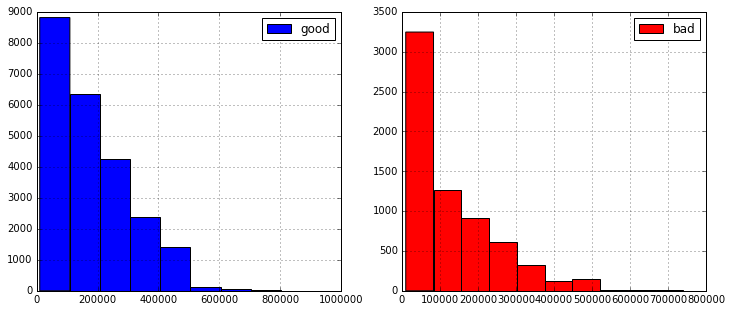

In [4]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
good.LIMIT_BAL.hist(label='good')
pylab.legend()

pylab.subplot(1,2,2)
bad.LIMIT_BAL.hist(color='red', label='bad')
pylab.legend()

### Из гистограмм видно, что распределения в обоих случаях похожи на распределение Пуассона с $\lambda$ близким к нулю. Далее проверим гипотезу о равенстве медиан.

### a) Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0.
### Строим с помощью метода бутстреп, так как он не делает предположений о распределении.

In [33]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [34]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
good_limit = good.LIMIT_BAL.values
bad_limit  = bad.LIMIT_BAL.values

In [8]:
np.random.seed(0)

good_limit_median = map(np.median, get_bootstrap_samples(good_limit, 1000))
bad_limit_median  = map(np.median, get_bootstrap_samples(bad_limit, 1000))

In [9]:
delta_median = map(lambda x: x[1] - x[0], zip(bad_limit_median, good_limit_median))

In [10]:
stat_intervals(delta_median)

array([ 60000.,  70000.])

### Видим, что разница между медианами довольно велика. 
### b) Проверим гипотезу о равенстве распределений. С помощью перестановочного критерия для независимых выборок.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [59]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [13]:
permutation_test(good_limit, bad_limit, 5000)

0.0001

### Видим, что p-value довольно мало, гипотеза о равенстве распределений уверенно отвергается.
### Полученные результаты практически значимы, поскольку отличие кредитных лимитов почти в 2 раза - это довольно большая разница и соответственно можно сделать вывод, что данный признак является полезным для модели.

## 2. Проверим гипотезу о различии гендерного состава групп.

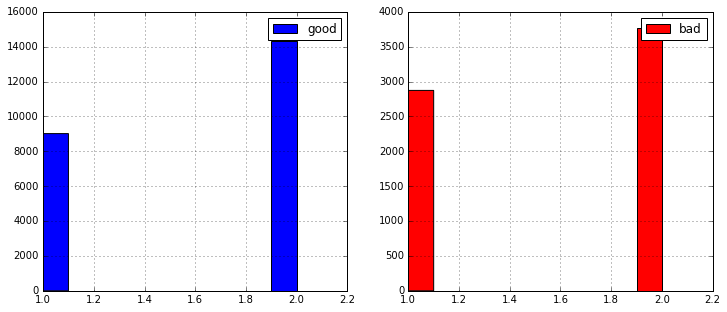

In [5]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
good.SEX.hist(label='good')
pylab.legend()

pylab.subplot(1,2,2)
bad.SEX.hist(color='red', label='bad')
pylab.legend()

#### По графикам видно, что женщин больше в обеих группах, но кажется, что среди хороших заемщиков их преобладание более значительно.

### Сравним доли мужчин в обоих выборках. Для этого построим доверительный интервал для разности долей, а затем проверим гипотезу о равенстве долей с помощью z-критерия.

In [14]:
n1 = good.SEX.shape[0]
n2 = bad.SEX.shape[0]
p1 = float(good[good.SEX == 1].shape[0]) / n1
p2 = float(bad[bad.SEX == 1].shape[0]) / n2

In [15]:
z = stats.norm.ppf(1 - 0.05 / 2.)
    
left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
   
(left_boundary, right_boundary)

(-0.060548077974896725, -0.033634932749628671)

### Видим, что доверительный интервал не содержит 0.
### Проверим гипотезу о равенстве долей.
$H_0\colon p1 = p2$

$H_1\colon p1 <> p2$

In [16]:
P = float(p1*n1 + p2*n2) / (n1 + n2)
z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

2 * (1 - stats.norm.cdf(np.abs(z_stat)))

4.4728665216098307e-12

### p-value очень мало, гипотеза об одинаковости гендерного состава групп уверенно отвергается.

### 3. Проверим связь образования и возврата долга.

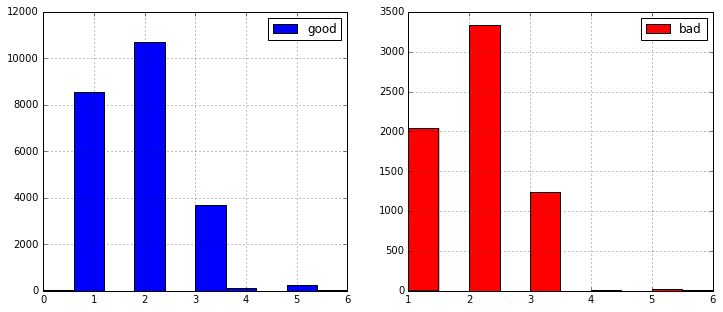

In [17]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
good.EDUCATION.hist(label='good')
pylab.legend()

pylab.subplot(1,2,2)
bad.EDUCATION.hist(color='red', label='bad')
pylab.legend()

### Гистограммы довольно похожи, кажется, что образование слабо влияет на возврат. Посмотрим более детально.

In [27]:
doctor_good = good[good.EDUCATION == 0].EDUCATION.shape[0]
magistr_good = good[good.EDUCATION == 1].EDUCATION.shape[0]
bach_good = good[good.EDUCATION == 2].EDUCATION.shape[0]
school_good = good[good.EDUCATION == 3].EDUCATION.shape[0]
low_good = good[good.EDUCATION == 4].EDUCATION.shape[0]
other_good = good[good.EDUCATION == 5].EDUCATION.shape[0]
unknown_good = good[good.EDUCATION == 6].EDUCATION.shape[0]

doctor_bad = bad[bad.EDUCATION == 0].EDUCATION.shape[0]
magistr_bad = bad[bad.EDUCATION == 1].EDUCATION.shape[0]
bach_bad = bad[bad.EDUCATION == 2].EDUCATION.shape[0]
school_bad = bad[bad.EDUCATION == 3].EDUCATION.shape[0]
low_bad = bad[bad.EDUCATION == 4].EDUCATION.shape[0]
other_bad = bad[bad.EDUCATION == 5].EDUCATION.shape[0]
unknown_bad = bad[bad.EDUCATION == 6].EDUCATION.shape[0]

diffs = np.array([doctor_good - doctor_bad, magistr_good - magistr_bad, bach_good - bach_bad, school_good - school_bad,
                 low_good - low_bad, other_good - other_bad, unknown_good - unknown_bad])
diffs

array([  14, 6513, 7370, 2443,  109,  244,   35])

### Видим, что значения довольно разные и по ним сложно сделать какие-либо выводы.
### Посмотрим на доли вернувших кредит по каждому образованию

In [28]:
parts = np.array([float(doctor_good)/ (doctor_good + doctor_bad), float(magistr_good) / (magistr_good + magistr_bad), 
                  float(bach_good) / (bach_good + bach_bad), float(school_good) / (school_good + school_bad),
                 float(low_good) / (low_good + low_bad), float(other_good) / (other_good + other_bad), 
                  float(unknown_good) / (unknown_good + unknown_bad)])
parts

array([ 1.        ,  0.80765234,  0.76265146,  0.74842384,  0.94308943,
        0.93571429,  0.84313725])

### Теперь все значения имеют масштаб от 0 до 1. Коэффициенты довольно похожи, видно, что образование действительно слабо влияет на невозврат долга, однако некоторые выводы сделать можно: 1) наилучшим индикатором того, что человек вернет долг, является докторское образование, так как все доктора вернули долг. 
### 2) наоборот, индикатором невозврата можно считать среднее образование (только школа), хотя и довольно слабо выраженным, коэффициент почти не отличается от такового для бакалавров.

In [24]:
chi2 = stats.chi2_contingency(table)
chi2

(156.79584412668356,
 9.0067099295085965e-34,
 3,
 array([[  8242.50483559,  10925.11505369,   3828.85179751,    353.52831321],
        [  2342.49516441,   3104.88494631,   1088.14820249,    100.47168679]]))

In [25]:
n = sum([sum(x) for x in table])
phi_cramera = np.sqrt(chi2[0] / (n * 2))
phi_cramera

0.05113202676783609

## 4. Семейное положение.

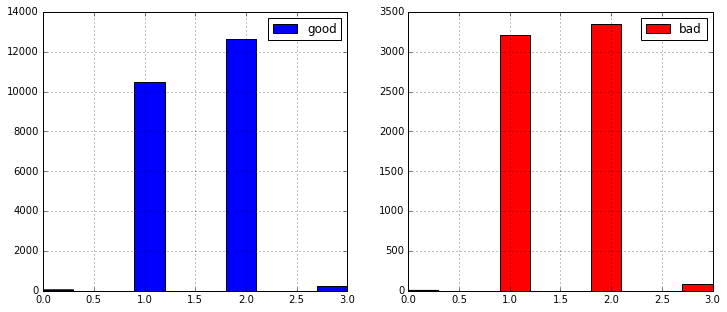

In [26]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
good.MARRIAGE.hist(label='good')
pylab.legend()

pylab.subplot(1,2,2)
bad.MARRIAGE.hist(color='red', label='bad')
pylab.legend()

### Гистограммы кажутся довольно похожими, вероятно, замужество слабо влияет на возврат. Проверим связь между признаками с помощью коэффициента Крамера и критерия хи-квадрат.

#### Таблица сопряженности

In [29]:
deny_good = good[good.MARRIAGE == 0].MARRIAGE.shape[0]
marr_good = good[good.MARRIAGE == 1].MARRIAGE.shape[0]
not_marr_good = good[good.MARRIAGE == 2].MARRIAGE.shape[0]
unknown_good = good[good.MARRIAGE == 3].MARRIAGE.shape[0]

deny_bad = bad[bad.MARRIAGE == 0].MARRIAGE.shape[0]
marr_bad = bad[bad.MARRIAGE == 1].MARRIAGE.shape[0]
not_marr_bad = bad[bad.MARRIAGE == 2].MARRIAGE.shape[0]
unknown_bad = bad[bad.MARRIAGE == 3].MARRIAGE.shape[0]

table = np.array([[deny_good, marr_good, not_marr_good, unknown_good], [deny_bad,marr_bad,not_marr_bad,unknown_bad]])
table

array([[   49, 10453, 12623,   239],
       [    5,  3206,  3341,    84]])

#### Видим, что условия применимости критерия хи-квадрат выполняются.

In [30]:
chi2 = stats.chi2_contingency(table)
chi2

(35.662395834336088,
 8.8258624575773752e-08,
 3,
 array([[  4.20552000e+01,   1.06376292e+04,   1.24327632e+04,
           2.51552400e+02],
        [  1.19448000e+01,   3.02137080e+03,   3.53123680e+03,
           7.14476000e+01]]))

In [31]:
n = sum([sum(x) for x in table])
phi_cramera = np.sqrt(chi2[0] / (n * 2))
phi_cramera

0.024379771613073028

### Коэффициент Крамера слабо отличается от нуля, а значит связь статуса замужества и дефолта невозврата действительно слабая.

## 5. Возраст

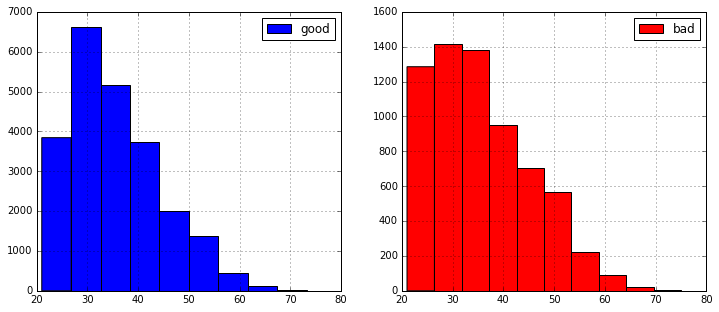

In [32]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
good.AGE.hist(label='good')
pylab.legend()

pylab.subplot(1,2,2)
bad.AGE.hist(color='red', label='bad')
pylab.legend()

#### Гистограммы несколько похожи, но различия все-таки наблюдаются.

### a) Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0. Строим с помощью метода бутстреп, так как он не делает предположений о распределении.

In [65]:
good_age = good.AGE.values
bad_age  = bad.AGE.values

np.median(good_age) - np.median(bad_age)

0.0

In [39]:
np.random.seed(0)

good_age_median = map(np.median, get_bootstrap_samples(good_age, 5000))
bad_age_median  = map(np.median, get_bootstrap_samples(bad_age, 5000))

In [46]:
delta_median = map(lambda x: x[1] - x[0], zip(good_age_median, bad_age_median))

In [58]:
stat_intervals(delta_median)

array([ 0.,  1.])

### Видим, что 0 хоть и является крайним значением, но все-таки входит в интервал, а значит не можем сказать однозначно.

### b) Проверим гипотезу о равенстве распределений. С помощью перестановочного критерия для независимых выборок.
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [63]:
permutation_test(good_age, bad_age, 5000)

0.014200000000000001

### Итого, имеем: по точечной оценке медианы выборок равны и доверительный интервал не смог отбросить нулевое значение, однако перестановочный критерий на уровне значимости 0.05 гипотезу о равенстве распределений отвергает. Значит, статистически мы не можем утверждать, что возраст не влияет на возврат кредита. Однако, видим, что полученные значения не являются практически значимыми, так как отличия возрастных категорий невелики среди обеих групп.